In [3]:

"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; 
sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')

import utils
import os

import residualize as resi

from stargazer.stargazer import Stargazer

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'
year = 1994
spec = '/home/mitch/Dropbox/data/mexico_enigh/spec/' + str(year)

In [4]:
os.chdir(processed)
df = pd.read_csv('data.csv').query('Y==@year')
df

/tmp/ipykernel_1611306/3972076100.py:2: DtypeWarning: Columns (70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv').query('Y==@year')


,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,deposito,terceros,pago_tar,deudas,monedas,casas,balance,otra_ero,clase_hog,nom_emp
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19940110060,1001,153,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9698,19943290210,32051,1004,4,900.0,0.0,245.34,0.0,1145.34,680.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9699,19943290230,32051,1004,4,1225.0,0.0,502.94,0.0,1727.94,1699.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9700,19943290231,32051,1004,4,1800.0,0.0,42.93,0.0,1842.93,619.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9701,19943290250,32051,1004,4,1542.0,0.0,1383.05,0.0,2925.05,1319.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
os.chdir(spec)
income = pd.read_csv('capital_income.csv')
expenditures = pd.read_csv('capital_expenditures.csv')

In [6]:
liquid_assets = ['expense_deposits_savings', 'income_withdrawal_savings',
                 'income_interest_savings_accounts', 'income_interest_shares_bonds',
                 'expense_loans_to_third_parties', 'expense_securities_shares_bond',
                 'expense_credit_card_payments', 'income_securities_bonds',
                 'expense_foreigncurrencies_perciousmetals_art']
illiquid_assets = ['income_interest_fixed_investments',
                   'income_land_landrental',
                   'income_rental_houses_buildings_other_realestate',
                   'income_hhbusiness_machinery_animal_equipment',
                   'income_realestate_mortgage'] # this has to be wrong ! 


In [7]:
df = (df.merge(income, how='inner', on='hhid')
      .merge(expenditures, how='inner', on='hhid'))

In [8]:
for asset in liquid_assets + illiquid_assets:
    print(asset + ':' + str(df[asset].mean()))

expense_deposits_savings:0.7399399399399399
income_withdrawal_savings:0.6654654654654655
income_interest_savings_accounts:0.01981981981981982
income_interest_shares_bonds:0.0006006006006006006
expense_loans_to_third_parties:0.0966966966966967
expense_securities_shares_bond:0.0012012012012012011
expense_credit_card_payments:0.13273273273273273
income_securities_bonds:0.004204204204204204
expense_foreigncurrencies_perciousmetals_art:0.03663663663663664
income_interest_fixed_investments:0.012612612612612612
income_land_landrental:0.013813813813813814
income_rental_houses_buildings_other_realestate:0.057057057057057055
income_hhbusiness_machinery_animal_equipment:0.010810810810810811
income_realestate_mortgage:0.003003003003003003


In [9]:
df['liquid_assets']   = df[liquid_assets].sum(axis   = 1)
df['illiquid_assets'] = df[illiquid_assets].sum(axis = 1)

df['liquid_assets'] = df['liquid_assets'].apply(lambda x : x > 0)
df['illiquid_assets'] = df['illiquid_assets'].apply(lambda x : x > 0)

In [10]:
income_sources = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income_sources].sum(axis=1)
df['income'] = df['income'] / df['hh_size']
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_personal']
df['consumption'] = df[consumption].sum(axis=1)
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
print(len(df))
df = (df.query('relationship_to_hhm == 1')); print(len(df))
df = df.query('income > 0'); print(len(df))
df = df.query('consumption > 0'); print(len(df))
df = df.query('age >= 25').query('age <= 60'); print(len(df))
#df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]; print(len(df))

1665
1632
1617
1617
1617


In [12]:
df['income_decile'] = utils.get_deciles(df['log_income'], weights=df['weight'])
df['income_quartile'] = utils.get_quartiles(df['log_income'], weights=df['weight'])

In [13]:
Z = 'C(income_quartile) + age + I(age**2) + C(sex) + C(education) + C(location_size)'

In [14]:
liquid_to_probit = [
                        'expense_deposits_savings', 
                        'income_withdrawal_savings', 
                        'expense_credit_card_payments',
                        'expense_loans_to_third_parties',
                        ]

illiquid_to_probit = [
                        'expense_deposits_savings', 
                        'expense_credit_card_payments',
                        'expense_loans_to_third_parties',
                        ]

In [15]:
models = {}
for x in liquid_to_probit:
    _, models[x] = utils.probit_residualize(df, x, Z, 'weight')

In [16]:
fits = [x.fit() for x in models.values()]
summaries = [x.fit().summary() for x in models.values()]
probits = Stargazer(fits)
probits

In [17]:
Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size) + C(location_size)'
df['log_income_resi'] = resi.residualize(df, 'log_income', Z)

In [18]:
to_resid = ['expense_deposits_savings', 'expense_loans_to_third_parties', 'expense_credit_card_payments', 'log_income']
for x in to_resid:
    df[x + '_resid'], _ = resi.logit_residualize(df, x, Z)

In [19]:
to_by_decile = ['expense_deposits_savings_resid', 'expense_loans_to_third_parties_resid', 'expense_credit_card_payments_resid']

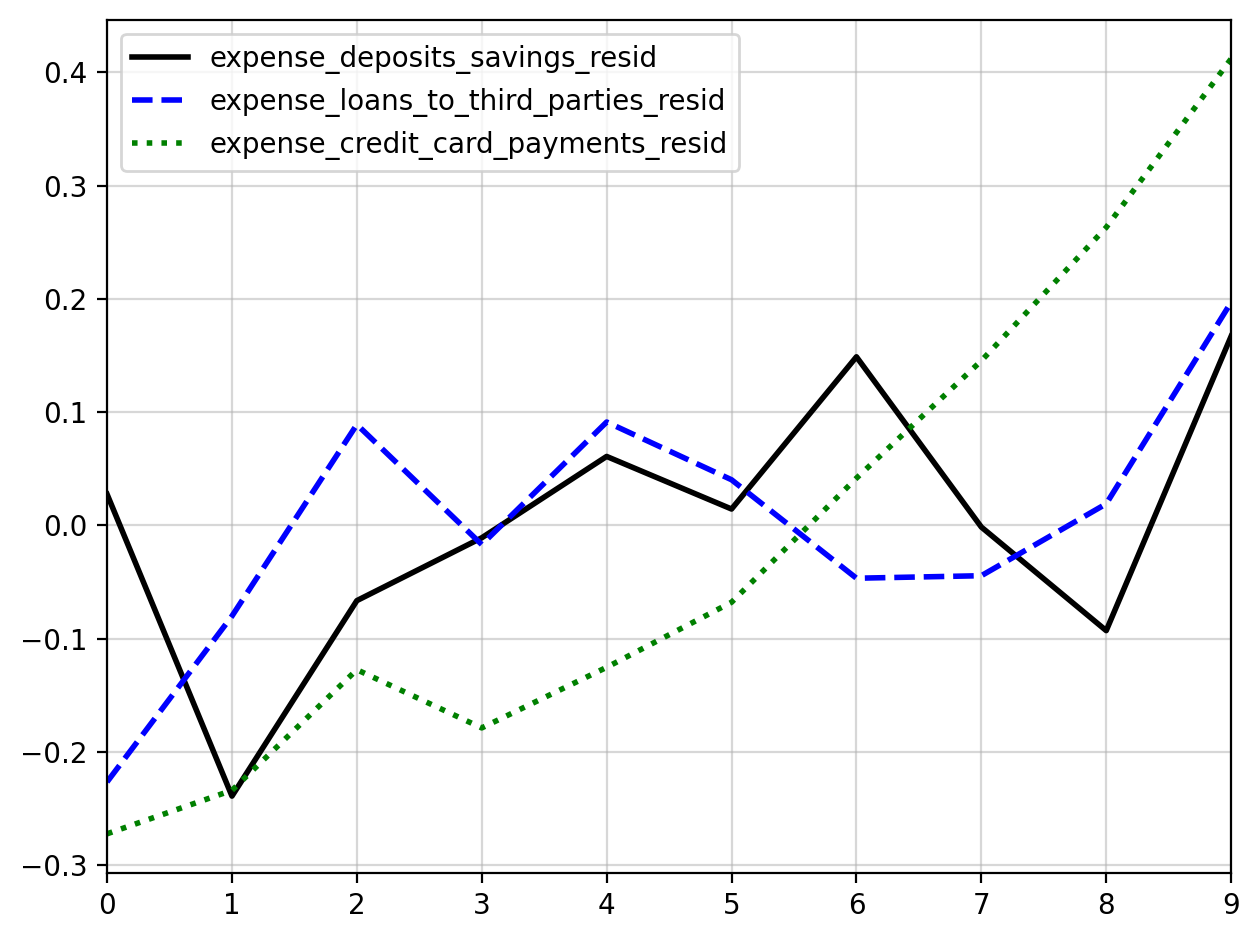

In [20]:
plt.clf()
for x in to_by_decile:
    plt.plot(utils.indicator_by_decile(df, 'log_income_resi', x, 'weight'), label=x)
plt.legend()
plt.show()

In [21]:
df['alt_expense_deposits_savings'] = (df['expense_deposits_savings'] > 0.00 * df['income']) + 0
df['alt_income_withdrawal_savings'] = (df['income_withdrawal_savings'] > 0.00 * df['income']) + 0
df['alt_expense_credit_card_payments'] = (df['expense_credit_card_payments'] > 0.00 * df['income']) + 0
alt_expense_deposits_savings = utils.indicator_by_decile(df, 'log_income', 'alt_expense_deposits_savings', 'weight')
alt_income_withdrawal_savings = utils.indicator_by_decile(df, 'log_income', 'alt_income_withdrawal_savings', 'weight')
alt_expense_credit_card_payments = utils.indicator_by_decile(df, 'log_income', 'alt_expense_credit_card_payments', 'weight')

note: it weaker relationship when residualize income
why is that?
is education the stronger predictor?

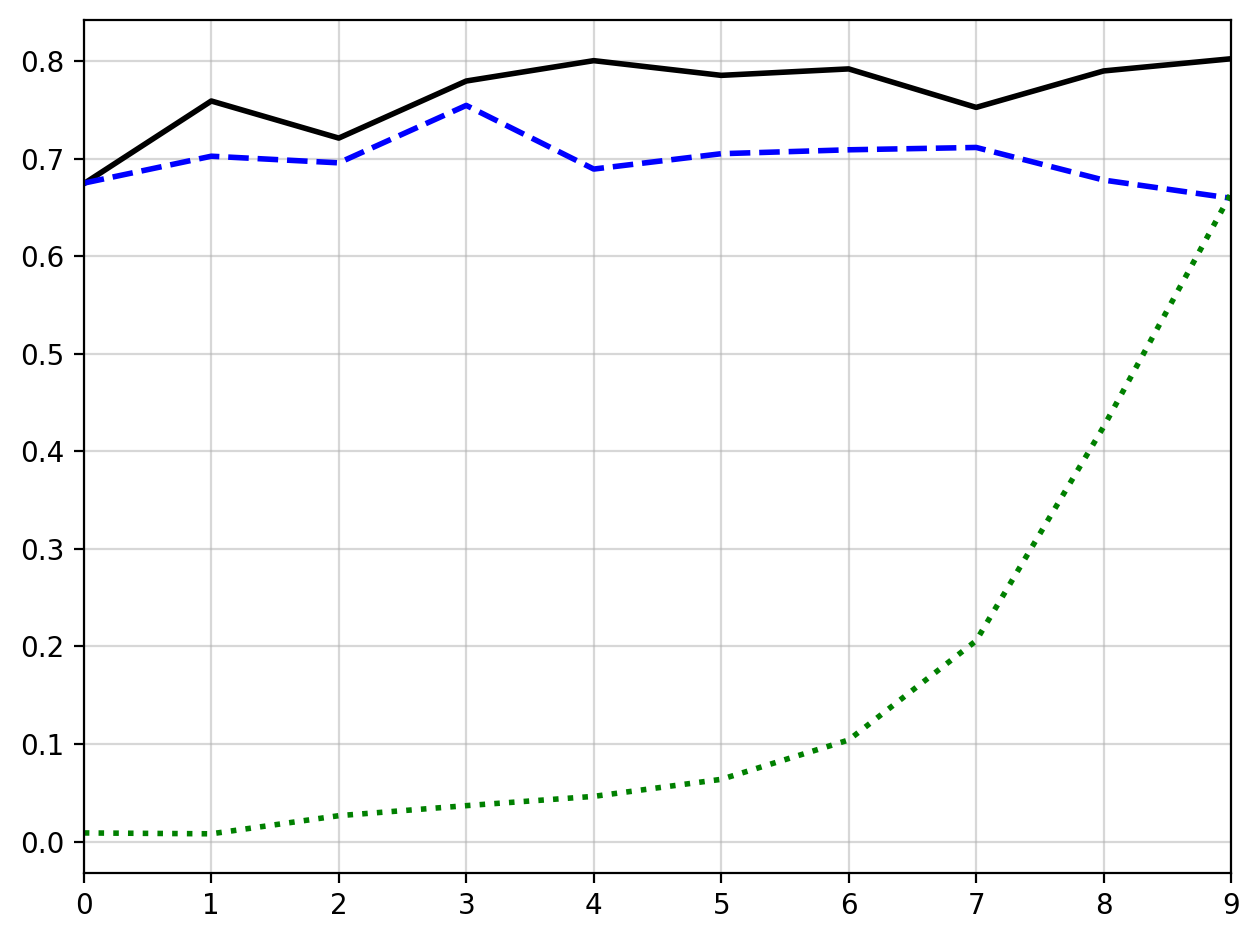

In [22]:
plt.clf()
plt.plot(alt_expense_deposits_savings)
plt.plot(alt_income_withdrawal_savings)
plt.plot(alt_expense_credit_card_payments)
plt.show()

In [23]:
df['net_savings'] = df['expense_deposits_savings'] - df['income_withdrawal_savings'] - df['expense_loans_to_third_parties']
df['saver'] = df['net_savings'] > 0
df['neither'] = df['net_savings'] = 0
df['borrower'] = df['net_savings'] < 0

saver = utils.indicator_by_decile(df, 'log_income', 'saver', 'weight')
borrower = utils.indicator_by_decile(df, 'log_income', 'borrower', 'weight')

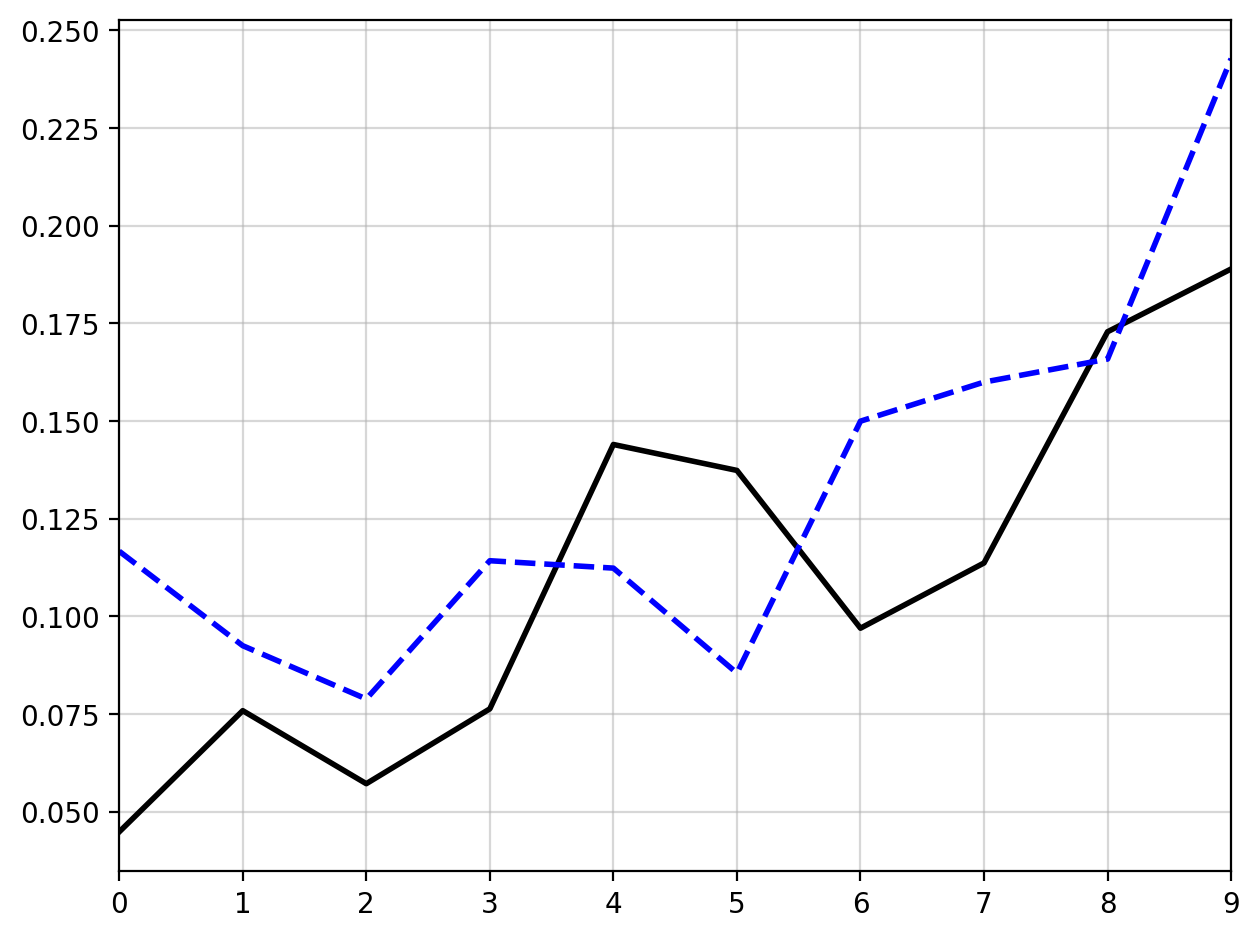

In [24]:
plt.clf()
plt.plot(saver)
plt.plot(borrower)
plt.show()

# Income Inequality

In [25]:
# want to measure different income shares
import panel_distribution_utils as pdu

In [26]:
def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


In [27]:
def gini(x, weights=None):
    if weights is None:
        weights = np.ones_like(x)
    # Calculate mean absolute deviation in two steps, for weights.
    count = np.multiply.outer(weights, weights)
    mad = np.abs(np.subtract.outer(x, x) * count).sum() / count.sum()
    rmad = mad / np.average(x, weights=weights)
    # Gini equals half the relative mean absolute deviation.
    return 0.5 * rmad

In [28]:
import importlib
importlib.reload(pdu)
top10 = 1 - pdu.share(0.90, df['log_income'], df['log_income'], df['weight'])
top20 = 1 - pdu.share(0.80, df['log_income'], df['log_income'], df['weight'])
bottom50 =  pdu.share(0.50, df['log_income'], df['log_income'], df['weight'])
bottom20 =  pdu.share(0.20, df['log_income'], df['log_income'], df['weight'])
focus = df[['log_income', 'income', 'weight']].dropna().astype('float64')
gini_data = gini(focus['income'], focus['weight'])

print(top10)
print(top20)
print(bottom50)
print(bottom20)
gini_data

NotImplementedError: 

In [ ]:
plt.clf()
for asset in liquid_assets:
    plt.plot(liquid_assets_by_decile[asset], label=asset)

plt.legend()
plt.show()

NameError: name 'liquid_assets_by_decile' is not defined

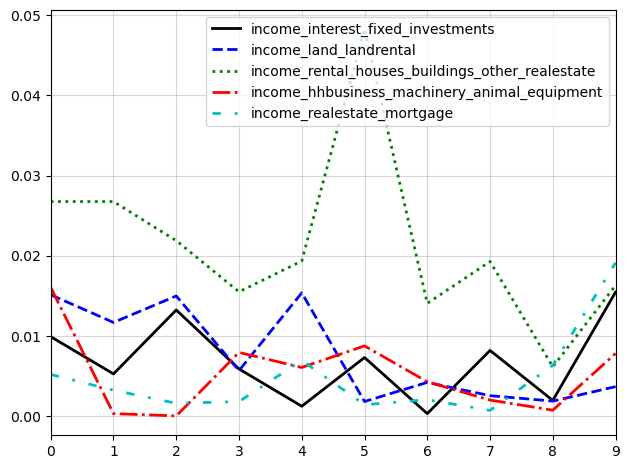

In [ ]:
plt.clf()
for asset in illiquid_assets:
    plt.plot(illiquid_assets_by_decile[asset], label=asset)

plt.legend()
plt.show()

In [ ]:
"""
income_by_decile = {}
for income_source in income.columns:
    income_by_decile[asset] = utils.indicator_by_decile(df, 'log_income', income_source, 'weight')

expense_by_decile = {}
for asset in illiquid_assets:
    expense_by_decile[asset] = utils.indicator_by_decile(df, 'log_income', asset, 'weight')
"""

"\nincome_by_decile = {}\nfor income_source in income.columns:\n    income_by_decile[asset] = utils.indicator_by_decile(df, 'log_income', income_source, 'weight')\n\nexpense_by_decile = {}\nfor asset in illiquid_assets:\n    expense_by_decile[asset] = utils.indicator_by_decile(df, 'log_income', asset, 'weight')\n"

In [ ]:
import patsy
Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size) + C(location_size)'
X = patsy.dmatrix(Z, df, return_type='dataframe')

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api.families.family.Binomial.links

model = sm.GLM(df['expense_deposits_savings'], X, freq_weights=df['weight'], family=sm.families.Binomial())
fit = model.fit()

ModuleNotFoundError: No module named 'statsmodels.api.families'; 'statsmodels.api' is not a package

In [ ]:
df['expense_deposits_savings_residualized'] = fit.resid_pearson
y = utils.indicator_by_decile(df, 'log_income', 'expense_deposits_savings_residualized', 'weight')
y_unresid = utils.indicator_by_decile(df, 'log_income', 'expense_deposits_savings', 'weight')

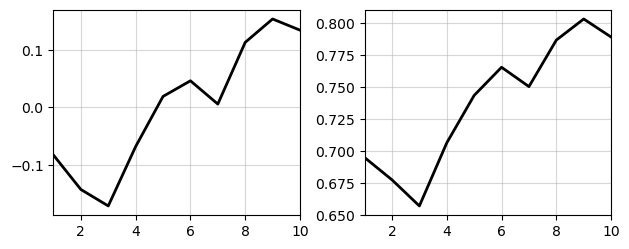

In [ ]:
deciles = np.arange(1, 11)
plt.clf()
plt.subplot(221)
plt.plot(deciles, y)

plt.subplot(222)
plt.plot(deciles, y_unresid)
plt.show()

finding: residualizing the other y variable is critical
todo: apply this methodology to MFL